## **Set Up**

In [1]:
# import all library
import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
import time
import tracemalloc
from scipy.linalg import orth

### Data Preparation

In [2]:
mat_content = sio.loadmat('assets/face.mat')
# mat_content # Let's see the content...

face_data = mat_content['X']
face_labels = mat_content['l']

x_train, x_test, y_train, y_test = [], [], [], []

n_classes = 52
images_per_class = 10

for i in range(n_classes):
    start_idx = i * images_per_class
    end_idx = start_idx + images_per_class

    x_train.append(face_data[:, start_idx:start_idx+8])
    x_test.append(face_data[:, start_idx+8:end_idx])

    y_train.append(face_labels[:, start_idx:start_idx+8])
    y_test.append(face_labels[:, start_idx+8:end_idx])

x_train, x_test = np.hstack(x_train), np.hstack(x_test)
y_train, y_test = np.hstack(y_train), np.hstack(y_test)

x_train = x_train.astype(np.int64)
x_test = x_test.astype(np.int64)

# Output the shapes of the training and testing sets
print(f"Training set shape: {x_train.shape}")
print(f"Test set shape: {x_test.shape}")

Training set shape: (2576, 416)
Test set shape: (2576, 104)


In [3]:
x_sub1, x_sub2, x_sub3, x_sub4 = [], [], [], []
y_sub1, y_sub2, y_sub3, y_sub4 = [], [], [], []

n_classes = 52
images_per_class = 8

for i in range(n_classes):
  x_sub1.append(x_train[:,i*images_per_class :i*images_per_class + 2])
  x_sub2.append(x_train[:,i*images_per_class+2 :i*images_per_class + 4])
  x_sub3.append(x_train[:,i*images_per_class+4 :i*images_per_class + 6])
  x_sub4.append(x_train[:,i*images_per_class+6 :i*images_per_class + 8])

  y_sub1.append(y_train[:,i*images_per_class :i*images_per_class + 2])
  y_sub2.append(y_train[:,i*images_per_class+2 :i*images_per_class + 4])
  y_sub3.append(y_train[:,i*images_per_class+4 :i*images_per_class + 6])
  y_sub4.append(y_train[:,i*images_per_class+6 :i*images_per_class + 8])

x_sub1, x_sub2, x_sub3, x_sub4 = np.hstack(x_sub1), np.hstack(x_sub2), np.hstack(x_sub3), np.hstack(x_sub4)
y_sub1, y_sub2, y_sub3, y_sub4 = np.hstack(y_sub1), np.hstack(y_sub2), np.hstack(y_sub3), np.hstack(y_sub4)

x_subs = [x_sub1, x_sub2, x_sub3, x_sub4]
y_subs = [y_sub1, y_sub2, y_sub3, y_sub4]

## Additional Functions

In [4]:
def get_mean_cov_mat(x_train):
    x_train_bar = np.average(x_train, axis=1).reshape(-1,1)
    A = x_train - x_train_bar
    S = np.matmul(A, A.T) / A.shape[1]
    return x_train_bar, S

In [5]:
def update_P(n_components, P_origin, x_sub_origin, x_sub_new, x_origin_bar, check_only_update_time=False):
    pca_sub = PCA(n_components=n_components)
    pca_S = PCA(n_components=n_components)

    if check_only_update_time:
        run_time, peak_memory1 = 0, 0
        P_new = pca_sub.fit(x_sub_new.T).components_.T
        
    else:
        tracemalloc.start()
        start_time = time.perf_counter()
        
        P_new = pca_sub.fit(x_sub_new.T).components_.T

        run_time = time.perf_counter() - start_time
        _, peak_memory1 = tracemalloc.get_traced_memory()
        tracemalloc.stop()

    x_new_bar = np.average(x_sub_new, axis=1).reshape(-1,1)

    # Get Phi matrix
    combined_matrix = np.hstack((P_origin, P_new, x_origin_bar - x_new_bar))
    Phi = orth(combined_matrix) 

    # Get Rotation matrix
    combined_x = np.concatenate((x_sub_origin, x_sub_new), axis=1)
    x_bar_new, S_2 = get_mean_cov_mat(combined_x)

    # Start: time and memory measure -----------------------------
    tracemalloc.start()
    start_time = time.perf_counter()

    R = pca_S.fit((Phi.T @ S_2 @ Phi)).components_.T

    run_time += time.perf_counter() - start_time
    _, peak_memory2 = tracemalloc.get_traced_memory()
    tracemalloc.stop()
    # End: time and memory measure ----------------------------------

    # Get new principal component vectors
    P_new = Phi@R

    return P_new, combined_x, x_bar_new, run_time, max(peak_memory1, peak_memory2)

In [6]:
def ipca_nn(n_components, x_subs, y_train, x_test, y_test, x_sub1=None, check_only_update_time=False):
    pca1 = PCA(n_components=n_components)
    x1_bar = np.average(x_subs[0], axis=1).reshape(-1,1)

    if check_only_update_time:
        run_time, peak_memory = 0, 0
        P1 = pca1.fit(x_subs[0].T).components_.T
    else:
        tracemalloc.start()
        start_time = time.perf_counter()
        P1 = pca1.fit(x_subs[0].T).components_.T

        run_time = time.perf_counter() - start_time
        _, peak_memory = tracemalloc.get_traced_memory()
        tracemalloc.stop()

    # Incrementally merge each eigenvectors
    P2, combined_x_2, x2_bar, run_time2, peak_memory2 = update_P(n_components, P1, x_subs[0], x_subs[1], x1_bar, check_only_update_time)
    run_time += run_time2
    peak_memory = max(peak_memory, peak_memory2)

    P3, combined_x_3, x3_bar, run_time3, peak_memory3 = update_P(n_components, P2, combined_x_2, x_subs[2], x2_bar, check_only_update_time)
    run_time += run_time3
    peak_memory = max(peak_memory, peak_memory3)

    P4, combined_x_4, x4_bar, run_time4, peak_memory4 = update_P(n_components, P3, combined_x_3, x_subs[3], x3_bar, check_only_update_time)
    run_time += run_time4
    peak_memory = max(peak_memory, peak_memory4)

    # Get reconstruction error
    A_test = x_test - x4_bar
    W_test = np.matmul(P4.T, A_test)
    x_test_rec = x4_bar + np.matmul(P4, W_test)
    rec_err = np.mean((x_test - x_test_rec)**2)


    # Applying NN algorithm
    x_train_proj = np.matmul(P4.T, x_train - x4_bar)
    x_test_proj = np.matmul(P4.T, x_test - x4_bar)

    nn = KNeighborsClassifier(n_neighbors=1)
    nn.fit(x_train_proj.T, y_train.reshape(-1))

    # Get accuracy
    y_pred = nn.predict(x_test_proj.T)
    accuracy = accuracy_score(y_test.T, y_pred)

    return accuracy, rec_err, run_time, peak_memory

In [7]:
def pca_nn(n_components, x_train, y_train, x_test, y_test, x_sub1=None, check_only_update_time=False):
    pca = PCA(n_components=n_components)
    
    if x_sub1 is None:
        tracemalloc.start()
        start_time = time.perf_counter()
        
        P = pca.fit(x_train.T).components_.T

        run_time = time.perf_counter() - start_time
        _, peak_memory = tracemalloc.get_traced_memory()
        tracemalloc.stop()

    else:
        tracemalloc.start()
        start_time = time.perf_counter()

        P = pca.fit(x_sub1.T).components_.T

        run_time = time.perf_counter() - start_time
        _, peak_memory = tracemalloc.get_traced_memory()
        tracemalloc.stop()

    # Get mean vector
    x_train_bar = np.average(x_train, axis=1).reshape(-1,1)

    # Get reconstruction error
    A_test = x_test - x_train_bar
    W_test = np.matmul(P.T, A_test)
    x_test_rec = x_train_bar + np.matmul(P, W_test)
    rec_err = np.mean((x_test - x_test_rec)**2)

    # Applying NN algorithm
    x_train_proj = np.matmul(P.T, x_train - x_train_bar)
    x_test_proj = np.matmul(P.T, x_test - x_train_bar)

    nn = KNeighborsClassifier(n_neighbors=1)
    nn.fit(x_train_proj.T, y_train.reshape(-1))

    # Get accuracy
    y_pred = nn.predict(x_test_proj.T)
    accuracy = accuracy_score(y_test.T, y_pred)

    return accuracy, rec_err, run_time, peak_memory

In [8]:
def print_results(accuracy, rec_err, run_time, peak_memory):
    print(f"Accuracy: {accuracy * 100:.2f}%")
    print(f"Reconstruction Error with eigenvectors (MSE): {rec_err:.3f}")
    print(f"Peak memory usage: {peak_memory / 10**6:.3f} MB")
    print(f"Execution Time: {run_time:.6f} seconds")

In [9]:
# Get Average Result
def avg_results(num_iter, func, num_bases, x_train, y_train, x_test, y_test, x_sub1=None, check_only_update_time=False):
    accuracy_avg, rec_err_avg, run_time_avg, peak_memory_avg = 0,0,0,0

    for i in range(num_iter):
        accuracy, rec_err, run_time, peak_memory = func(num_bases, x_train, y_train, x_test, y_test, x_sub1, check_only_update_time)
    
        accuracy_avg += accuracy
        rec_err_avg += rec_err
        run_time_avg += run_time
        peak_memory_avg += peak_memory
    
    accuracy_avg /= num_iter
    rec_err_avg /= num_iter
    run_time_avg /= num_iter
    peak_memory_avg /= num_iter

    return accuracy_avg, rec_err_avg, run_time_avg,  peak_memory_avg

## **Q2. Incremental PCA**

### Incremental PCA

In [10]:
accuracy, rec_err, run_time, peak_memory = ipca_nn(3, x_subs, y_train, x_test, y_test, check_only_update_time=True)

print_results(accuracy, rec_err, run_time, peak_memory)

Accuracy: 24.04%
Reconstruction Error with eigenvectors (MSE): 975.537
Peak memory usage: 0.145 MB
Execution Time: 0.008079 seconds


### Batch PCA

In [11]:
accuracy, rec_err, run_time, peak_memory = pca_nn(3, x_train, y_train, x_test, y_test)

print_results(accuracy, rec_err, run_time, peak_memory)

Accuracy: 21.15%
Reconstruction Error with eigenvectors (MSE): 978.244
Peak memory usage: 18.040 MB
Execution Time: 0.017155 seconds


### Sub1 PCA

In [12]:
accuracy, rec_err, run_time, peak_memory = pca_nn(5, x_train, y_train, x_test, y_test, x_sub1)

print_results(accuracy, rec_err, run_time, peak_memory)

Accuracy: 34.62%
Reconstruction Error with eigenvectors (MSE): 903.450
Peak memory usage: 5.274 MB
Execution Time: 0.009626 seconds


### Get overall Results with average values

In [15]:
# interval = 10
num_iter = 15
num_base_vecs = [1, 10, 30, 50, 70, 100]
check_only_update_time=True

ipca_acc_result, batch_acc_result, sub1_acc_result = [], [], []
ipca_rec_err_result, batch_rec_err_result, sub1_rec_err_result = [], [], []
ipca_runtime_result, batch_runtime_result, sub1_runtime_result = [], [], []
ipca_peak_mem_result, batch_peak_mem_result, sub1_peak_mem_result = [], [], []


for i in range(len(num_base_vecs)):
    # num_bases = interval*i
    # num_base_vecs.append(num_bases)
    num_bases = num_base_vecs[i]
    
    # Get each PCA result
    ipca_accuracy, ipca_rec_err, ipca_run_time, ipca_peak_memory = avg_results(num_iter, ipca_nn, num_bases, x_subs, y_train, x_test, y_test, check_only_update_time=check_only_update_time)
    batch_accuracy, batch_rec_err, batch_run_time, batch_peak_memory = avg_results(num_iter, pca_nn, num_bases, x_train, y_train, x_test, y_test)
    sub1_accuracy, sub1_rec_err, sub1_run_time, sub1_peak_memory = avg_results(num_iter, pca_nn, num_bases, x_train, y_train, x_test, y_test, x_sub1)

    # accuracy arrays
    ipca_acc_result.append(ipca_accuracy)
    batch_acc_result.append(batch_accuracy)
    sub1_acc_result.append(sub1_accuracy)

    # reconstruction error arrays
    ipca_rec_err_result.append(ipca_rec_err)
    batch_rec_err_result.append(batch_rec_err)
    sub1_rec_err_result.append(sub1_rec_err)

    # runtime arrays -> seconds
    ipca_runtime_result.append(ipca_run_time)
    batch_runtime_result.append(batch_run_time)
    sub1_runtime_result.append(sub1_run_time)
    

    # peak memory arrays -> Mega Bite (MB)
    ipca_peak_mem_result.append(ipca_peak_memory / (1024**2))
    batch_peak_mem_result.append(batch_peak_memory / (1024**2))
    sub1_peak_mem_result.append(sub1_peak_memory / (1024**2))

### Comparision runtime

In [11]:
# interval = 10
num_iter = 15
num_base_vecs = [1, 10, 30, 50, 70, 100]

ipca_runtime_result_all, ipca_runtime_result_update, batch_runtime_result, sub1_runtime_result = [], [], [], []


for i in range(len(num_base_vecs)):
    num_bases = num_base_vecs[i]
    
    # Get each PCA result
    _, _, ipca_run_time_all, _ = avg_results(num_iter, ipca_nn, num_bases, x_subs, y_train, x_test, y_test, check_only_update_time=False)
    _, _, ipca_run_time_update, _ = avg_results(num_iter, ipca_nn, num_bases, x_subs, y_train, x_test, y_test, check_only_update_time=True)
    _, _, batch_run_time, _ = avg_results(num_iter, pca_nn, num_bases, x_train, y_train, x_test, y_test)
    _, _, sub1_run_time, _ = avg_results(num_iter, pca_nn, num_bases, x_train, y_train, x_test, y_test, x_sub1)

    # runtime arrays -> seconds
    ipca_runtime_result_all.append(ipca_run_time_all)
    ipca_runtime_result_update.append(ipca_run_time_update)
    batch_runtime_result.append(batch_run_time)
    sub1_runtime_result.append(sub1_run_time)

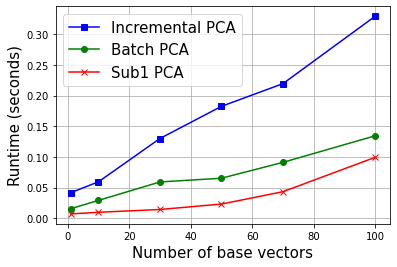

In [12]:
# Plot runtime on the second subplot
plt.plot(num_base_vecs, ipca_runtime_result_all, label='Incremental PCA', marker='s', linestyle='-', color='b')
plt.plot(num_base_vecs, batch_runtime_result, label='Batch PCA', marker='o', linestyle='-', color='g')
plt.plot(num_base_vecs, sub1_runtime_result, label='Sub1 PCA', marker='x', linestyle='-', color='r')
plt.xlabel('Number of base vectors', fontsize=15)
plt.ylabel('Runtime (seconds)', fontsize=15)
# plt.title('Runtime over number of base vectors')
plt.legend(fontsize=15)
plt.grid(True)

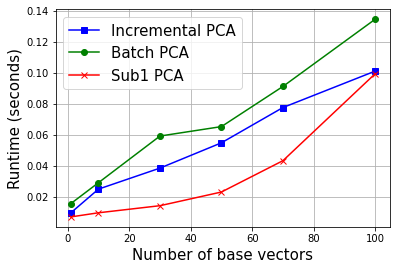

In [13]:
# Plot runtime on the second subplot
plt.plot(num_base_vecs, ipca_runtime_result_update, label='Incremental PCA', marker='s', linestyle='-', color='b')
plt.plot(num_base_vecs, batch_runtime_result, label='Batch PCA', marker='o', linestyle='-', color='g')
plt.plot(num_base_vecs, sub1_runtime_result, label='Sub1 PCA', marker='x', linestyle='-', color='r')
plt.xlabel('Number of base vectors', fontsize=15)
plt.ylabel('Runtime (seconds)', fontsize=15)
# plt.title('Runtime over number of base vectors')
plt.legend(fontsize=15)
plt.grid(True)

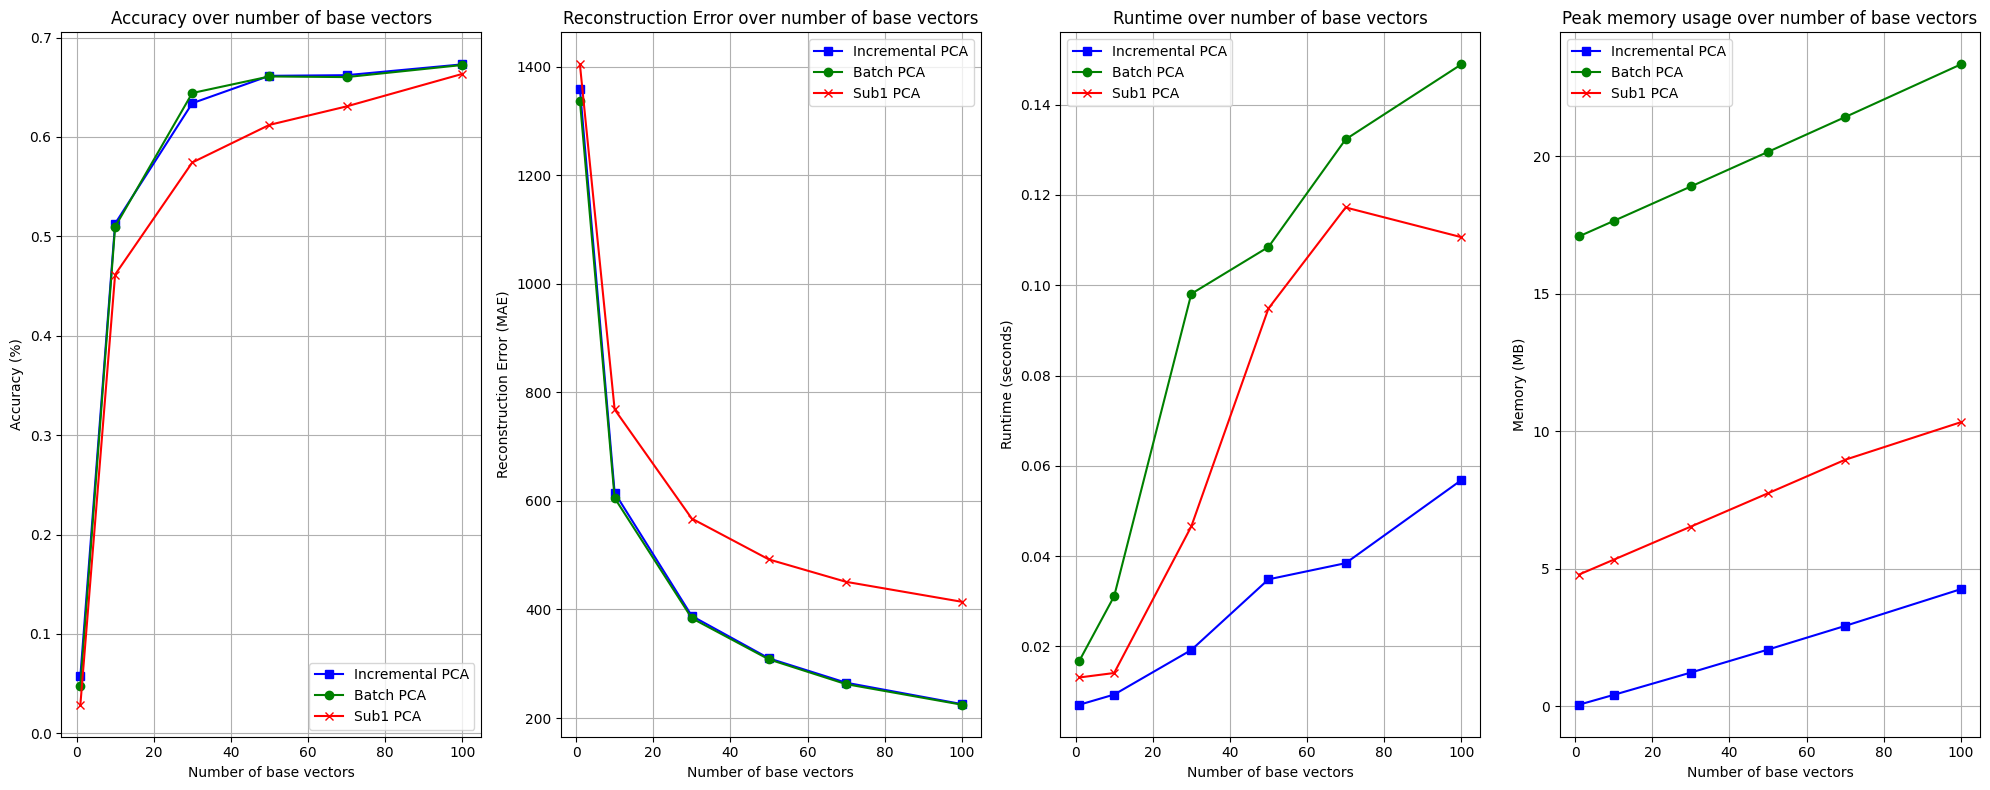

In [16]:
fig, axes = plt.subplots(1, 4, figsize=(20, 8))

# Plot accuracy on the first subplot
axes[0].plot(num_base_vecs, ipca_acc_result, label='Incremental PCA', marker='s', linestyle='-', color='b')
axes[0].plot(num_base_vecs, batch_acc_result, label='Batch PCA', marker='o', linestyle='-', color='g')
axes[0].plot(num_base_vecs, sub1_acc_result, label='Sub1 PCA', marker='x', linestyle='-', color='r')
axes[0].set_xlabel('Number of base vectors')
axes[0].set_ylabel('Accuracy (%)')
axes[0].set_title('Accuracy over number of base vectors')
axes[0].legend()
axes[0].grid(True)

# Plot runtime on the second subplot
axes[1].plot(num_base_vecs, ipca_rec_err_result, label='Incremental PCA', marker='s', linestyle='-', color='b')
axes[1].plot(num_base_vecs, batch_rec_err_result, label='Batch PCA', marker='o', linestyle='-', color='g')
axes[1].plot(num_base_vecs, sub1_rec_err_result, label='Sub1 PCA', marker='x', linestyle='-', color='r')
axes[1].set_xlabel('Number of base vectors')
axes[1].set_ylabel('Reconstruction Error (MAE)')  # Customize based on your runtime units
axes[1].set_title('Reconstruction Error over number of base vectors')
axes[1].legend()
axes[1].grid(True)

# Plot runtime on the second subplot
axes[2].plot(num_base_vecs, ipca_runtime_result, label='Incremental PCA', marker='s', linestyle='-', color='b')
axes[2].plot(num_base_vecs, batch_runtime_result, label='Batch PCA', marker='o', linestyle='-', color='g')
axes[2].plot(num_base_vecs, sub1_runtime_result, label='Sub1 PCA', marker='x', linestyle='-', color='r')
axes[2].set_xlabel('Number of base vectors')
axes[2].set_ylabel('Runtime (seconds)')  # Customize based on your runtime units
axes[2].set_title('Runtime over number of base vectors')
axes[2].legend()
axes[2].grid(True)

# Plot Peak memory usage on third subplot
axes[3].plot(num_base_vecs, ipca_peak_mem_result, label='Incremental PCA', marker='s', linestyle='-', color='b')
axes[3].plot(num_base_vecs, batch_peak_mem_result, label='Batch PCA', marker='o', linestyle='-', color='g')
axes[3].plot(num_base_vecs, sub1_peak_mem_result, label='Sub1 PCA', marker='x', linestyle='-', color='r')
axes[3].set_xlabel('Number of base vectors')
axes[3].set_ylabel('Memory (MB)')  # Customize based on your runtime units
axes[3].set_title('Peak memory usage over number of base vectors')
axes[3].legend()
axes[3].grid(True)

# Display the combined plot
plt.tight_layout()  # Adjust layout for better spacing
plt.show()

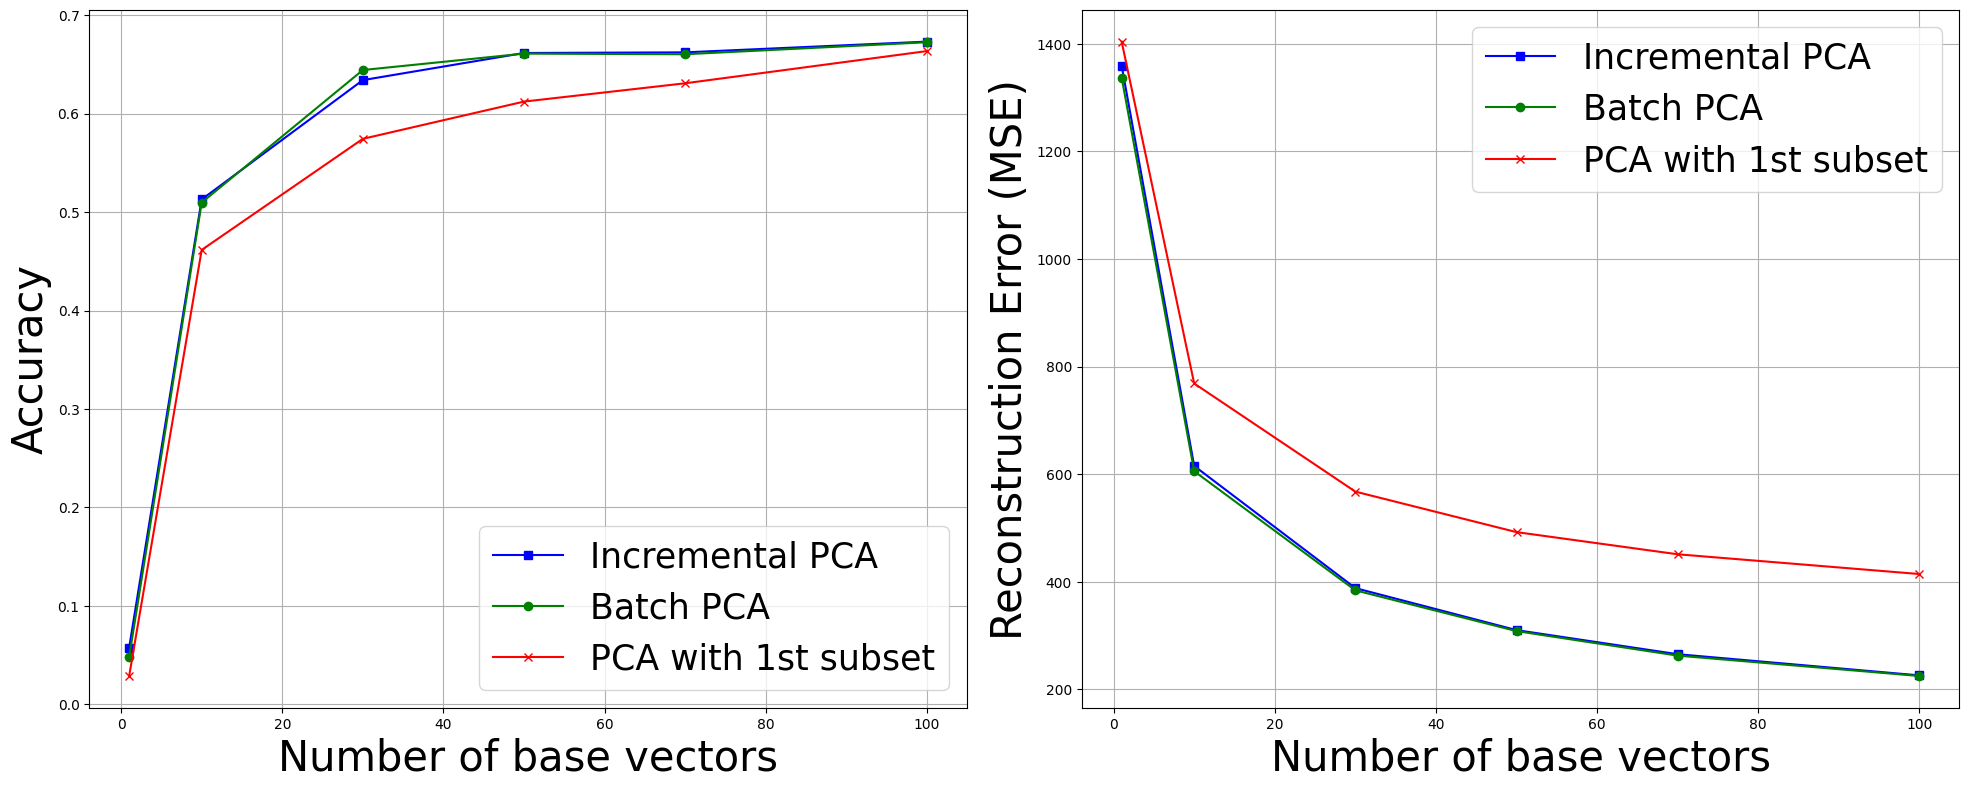

In [17]:
fig, axes = plt.subplots(1, 2, figsize=(20, 8))

# Plot accuracy on the first subplot
axes[0].plot(num_base_vecs, ipca_acc_result, label='Incremental PCA', marker='s', linestyle='-', color='b')
axes[0].plot(num_base_vecs, batch_acc_result, label='Batch PCA', marker='o', linestyle='-', color='g')
axes[0].plot(num_base_vecs, sub1_acc_result, label='PCA with 1st subset', marker='x', linestyle='-', color='r')
axes[0].set_xlabel('Number of base vectors', fontsize=30)
axes[0].set_ylabel('Accuracy', fontsize=30)
# axes[0].set_title('(a) Accuracy', fontsize=25)
axes[0].legend(fontsize=25)
axes[0].grid(True)

plt.subplots_adjust(wspace=2)

# Plot runtime on the second subplot
axes[1].plot(num_base_vecs, ipca_rec_err_result, label='Incremental PCA', marker='s', linestyle='-', color='b')
axes[1].plot(num_base_vecs, batch_rec_err_result, label='Batch PCA', marker='o', linestyle='-', color='g')
axes[1].plot(num_base_vecs, sub1_rec_err_result, label='PCA with 1st subset', marker='x', linestyle='-', color='r')
axes[1].set_xlabel('Number of base vectors', fontsize=30)
axes[1].set_ylabel('Reconstruction Error (MSE)', fontsize=30)  # Customize based on your runtime units
# axes[1].set_title('(b) Reconstruction Error' , fontsize=25)
axes[1].legend(fontsize=25)
axes[1].grid(True)

# Display the combined plot
plt.tight_layout()  # Adjust layout for better spacing
plt.show()

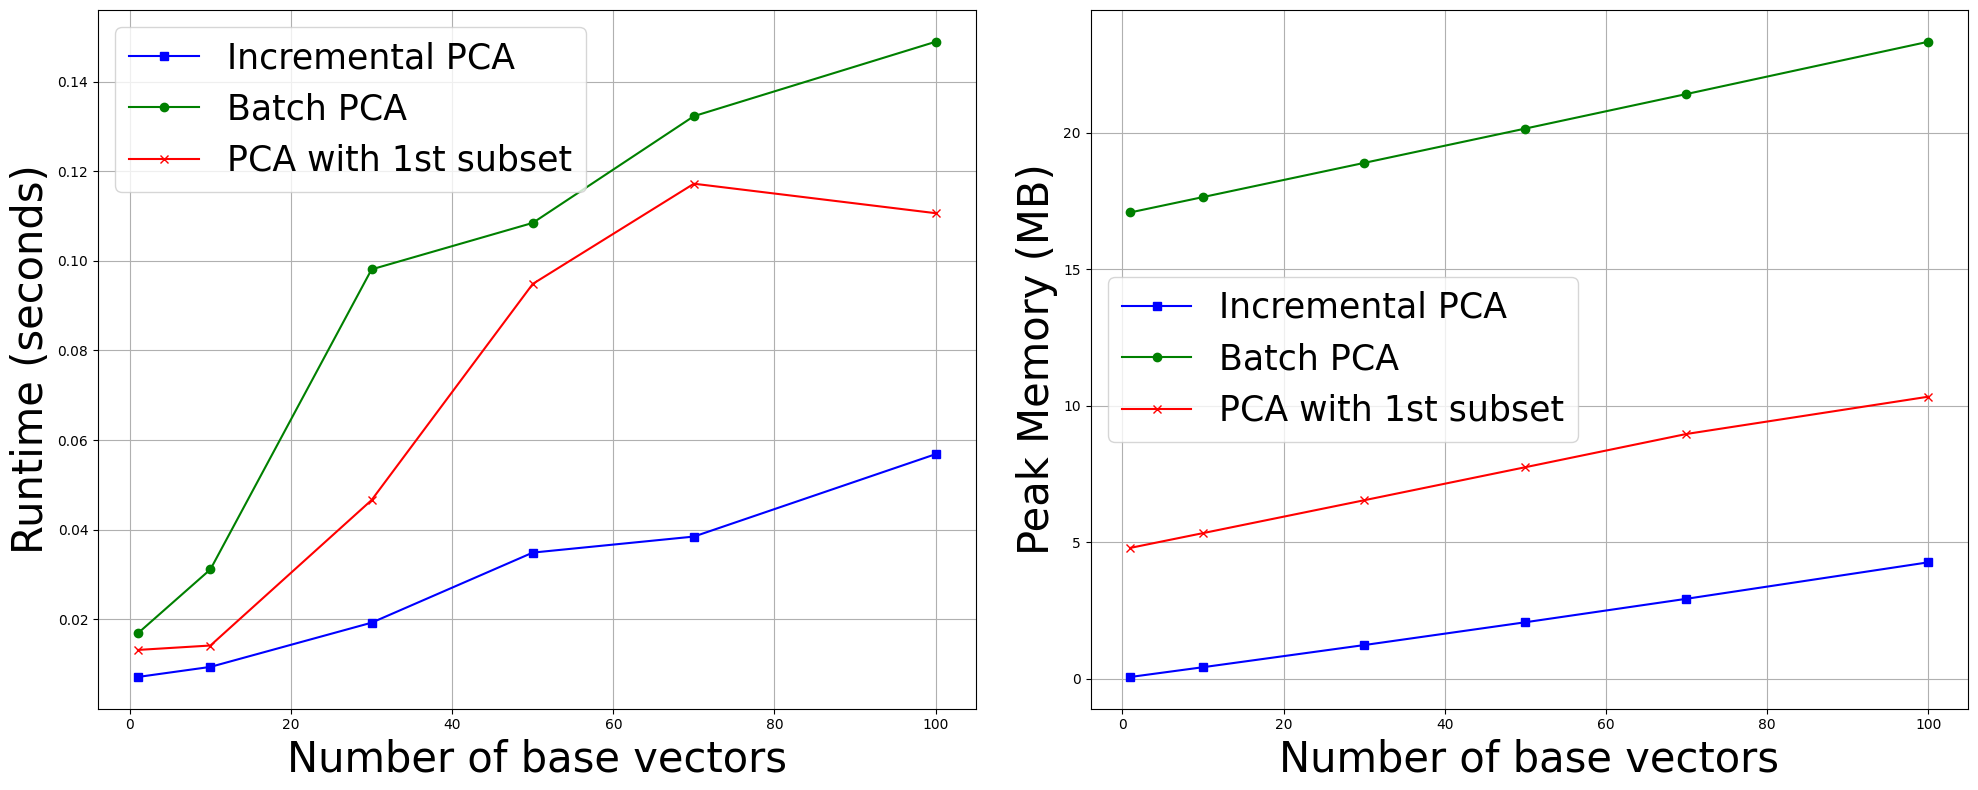

In [18]:
fig, axes = plt.subplots(1, 2, figsize=(20, 8))

# Plot runtime on the second subplot
axes[0].plot(num_base_vecs, ipca_runtime_result, label='Incremental PCA', marker='s', linestyle='-', color='b')
axes[0].plot(num_base_vecs, batch_runtime_result, label='Batch PCA', marker='o', linestyle='-', color='g')
axes[0].plot(num_base_vecs, sub1_runtime_result, label='PCA with 1st subset', marker='x', linestyle='-', color='r')
axes[0].set_xlabel('Number of base vectors', fontsize=30)
axes[0].set_ylabel('Runtime (seconds)', fontsize=30)
# axes[0].set_title('(a) Runtime', fontsize=25)
axes[0].legend(fontsize=25)
axes[0].grid(True)

plt.subplots_adjust(wspace=2)

# Plot Peak memory usage on third subplot
axes[1].plot(num_base_vecs, ipca_peak_mem_result, label='Incremental PCA', marker='s', linestyle='-', color='b')
axes[1].plot(num_base_vecs, batch_peak_mem_result, label='Batch PCA', marker='o', linestyle='-', color='g')
axes[1].plot(num_base_vecs, sub1_peak_mem_result, label='PCA with 1st subset', marker='x', linestyle='-', color='r')
axes[1].set_xlabel('Number of base vectors', fontsize=30)
axes[1].set_ylabel('Peak Memory (MB)', fontsize=30)
# axes[1].set_title('(b) Peak Memory Usage', fontsize=25)
axes[1].legend(fontsize=25)
axes[1].grid(True)

# Display the combined plot
plt.tight_layout()  # Adjust layout for better spacing
plt.show()

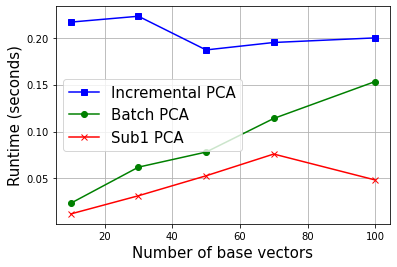

In [77]:
# Plot runtime on the second subplot
plt.plot(num_base_vecs, ipca_runtime_result_all, label='Incremental PCA', marker='s', linestyle='-', color='b')
# plt.plot(num_base_vecs, ipca_runtime_result_update, label='Incremental PCA, computing R', marker='x', linestyle='-', color='purple')
plt.plot(num_base_vecs, batch_runtime_result, label='Batch PCA', marker='o', linestyle='-', color='g')
plt.plot(num_base_vecs, sub1_runtime_result, label='Sub1 PCA', marker='x', linestyle='-', color='r')
plt.xlabel('Number of base vectors', fontsize=15)
plt.ylabel('Runtime (seconds)', fontsize=15)
# plt.title('Runtime over number of base vectors')
plt.legend(fontsize=15)
plt.grid(True)

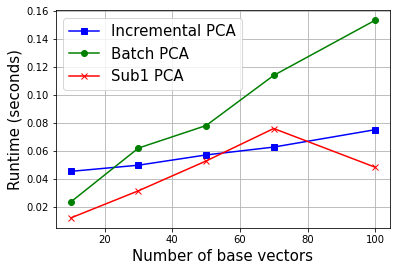

In [78]:
# Plot runtime on the second subplot
plt.plot(num_base_vecs, ipca_runtime_result_update, label='Incremental PCA', marker='s', linestyle='-', color='b')
# plt.plot(num_base_vecs, ipca_runtime_result_update, label='Incremental PCA, computing R', marker='x', linestyle='-', color='purple')
plt.plot(num_base_vecs, batch_runtime_result, label='Batch PCA', marker='o', linestyle='-', color='g')
plt.plot(num_base_vecs, sub1_runtime_result, label='Sub1 PCA', marker='x', linestyle='-', color='r')
plt.xlabel('Number of base vectors', fontsize=15)
plt.ylabel('Runtime (seconds)', fontsize=15)
# plt.title('Runtime over number of base vectors')
plt.legend(fontsize=15)
plt.grid(True)

